# Goals
- Regression Models (Random Forest, XGBoost) to predict billing amount
- Classification models (Random Forest, XGBoost, KNN) to predict medical condition
- Clustering (K-Means) (?)

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/healthcare-dataset/healthcare_dataset.csv


In [2]:
df = pd.read_csv("/kaggle/input/healthcare-dataset/healthcare_dataset.csv")

In [3]:
df.head(5)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [4]:
df.columns

Index(['Name', 'Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Date of Admission', 'Doctor', 'Hospital', 'Insurance Provider',
       'Billing Amount', 'Room Number', 'Admission Type', 'Discharge Date',
       'Medication', 'Test Results'],
      dtype='object')

# EDA

In [5]:
numerical_columns = df.select_dtypes(include=["int64", "float64"])
categorical_columns = df.select_dtypes(include=["object"])

In [6]:
numerical_columns.describe()

,Age,Billing Amount,Room Number
count,55500.000000,55500.000000,55500.000000
mean,51.539459,25539.316097,301.134829
std,19.602454,14211.454431,115.243069
min,13.000000,-2008.492140,101.000000
25%,35.000000,13241.224652,202.000000
50%,52.000000,25538.069376,302.000000
75%,68.000000,37820.508436,401.000000
max,89.000000,52764.276736,500.000000


It seems that Age and Billing would be the only numerical columns that would help modeling since room number doesn't convey any medical or clinical meaning. Hopefully, doctors at any hospital treat everyone equally regardless of their room number :)

In [7]:
categorical_columns.describe()

,Name,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Admission Type,Discharge Date,Medication,Test Results
count,55500,55500,55500,55500,55500,55500,55500,55500,55500,55500,55500,55500
unique,49992,2,8,6,1827,40341,39876,5,3,1856,5,3
top,DAvId muNoZ,Male,A-,Arthritis,2024-03-16,Michael Smith,LLC Smith,Cigna,Elective,2020-03-15,Lipitor,Abnormal
freq,3,27774,6969,9308,50,27,44,11249,18655,53,11140,18627


As stated by the provider of this dataset, we can treat this dataset as a Multi-class Classification problem to solve for the Test Results columns. 

In [8]:
grouped_df = df.groupby(df.columns.tolist(), as_index=False).size()
grouped_df.loc[grouped_df["size"] > 1].head(3)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results,size
50,ABIgaIL YOung,41,Female,O+,Hypertension,2022-12-15,Edward Kramer,Moore-Mcdaniel,UnitedHealthcare,1983.568297,192,Elective,2023-01-13,Ibuprofen,Normal,2
195,ALIcia taYLoR,78,Male,O+,Asthma,2022-09-18,Dawn Burton,Wright LLC,Aetna,31465.274979,149,Elective,2022-10-15,Aspirin,Inconclusive,2
563,AMy GREEN,79,Female,B+,Obesity,2021-03-30,Brett Johnson,Taylor-Williamson,UnitedHealthcare,23402.358491,249,Elective,2021-04-27,Penicillin,Abnormal,2


In [9]:
df_deduped = df.drop_duplicates()
df_deduped.loc[df_deduped["Name"] == "ABIgaIL YOung"]

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
42407,ABIgaIL YOung,41,Female,O+,Hypertension,2022-12-15,Edward Kramer,Moore-Mcdaniel,UnitedHealthcare,1983.568297,192,Elective,2023-01-13,Ibuprofen,Normal


In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df.loc[df["Name"] == "ABIgaIL YOung"]

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
42407,ABIgaIL YOung,41,Female,O+,Hypertension,2022-12-15,Edward Kramer,Moore-Mcdaniel,UnitedHealthcare,1983.568297,192,Elective,2023-01-13,Ibuprofen,Normal


In [12]:
df.duplicated().sum()

0

# Data Visualizations

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df.groupby("Age").size().head(3)

Age
13    14
14    18
15    28
dtype: int64

In [15]:
df.groupby("Age").size().reset_index(name="Count").head(10)

,Age,Count
0,13,14
1,14,18
2,15,28
3,16,24
4,17,32
5,18,770
6,19,791
7,20,744
8,21,817
9,22,810


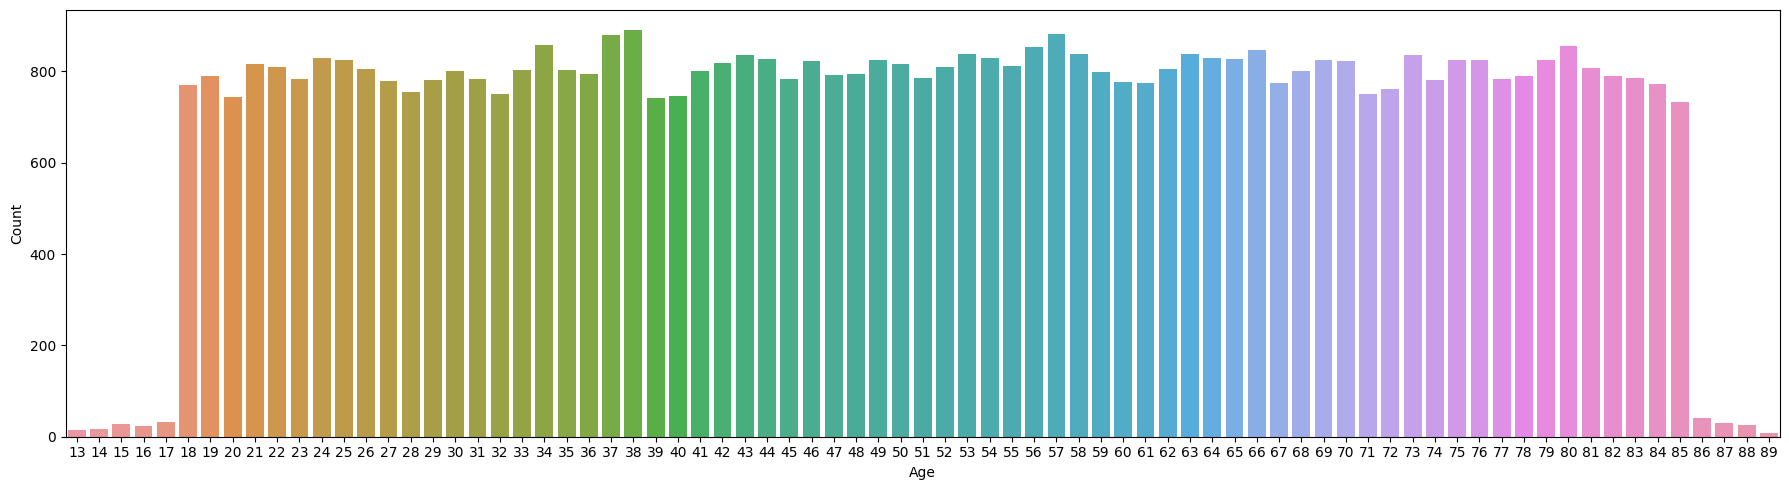

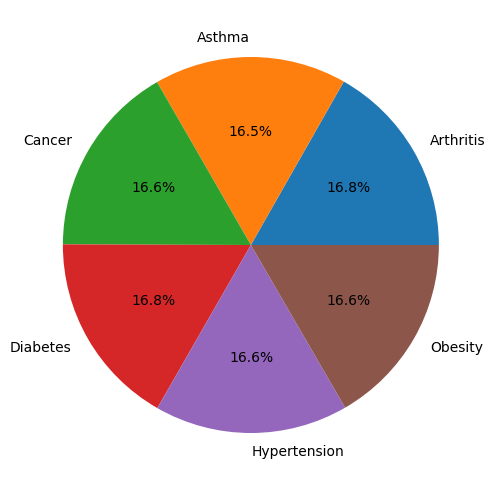

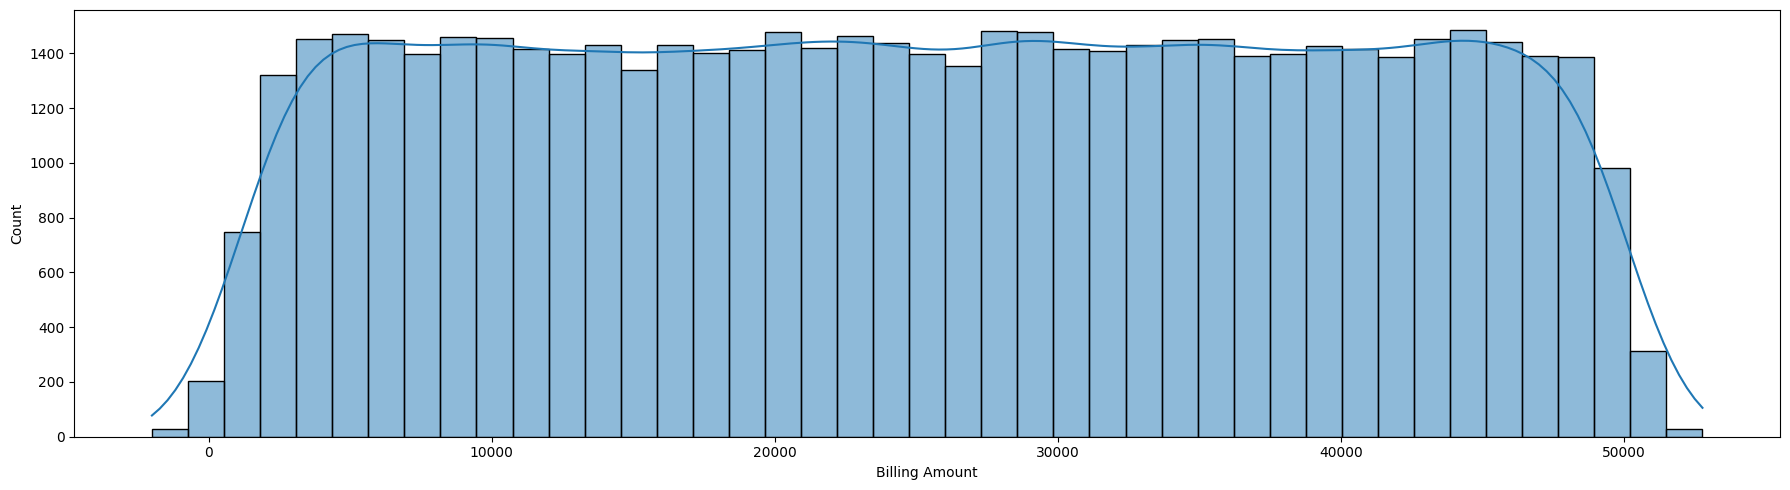

In [16]:
plt.rcParams["figure.figsize"] = [18, 5]
def show_plot():
    plt.tight_layout()
    plt.show()

# =======================================
# Age counts barplot
# =======================================
age_count = df.groupby("Age").size().reset_index(name="Count")
sns.barplot(data=age_count, x="Age", y="Count")
show_plot()

# =======================================
# Medical Conditions Pie Chart
# =======================================
medical_condition_df = df.groupby("Medical Condition") \
                         .size() \
                         .reset_index(name="Count")
plt.pie(medical_condition_df["Count"], 
        labels=medical_condition_df["Medical Condition"], 
        autopct="%1.1f%%")
show_plot()

# =======================================
# Billing Histogram Plot
# A negative amount could meam
# overpayment, resulting in a refund
# =======================================
sns.histplot(data=df, x="Billing Amount", kde=True)
show_plot()

In [17]:
for col in df.columns:
    if col != "Test Results":
        print(col)

Name
Age
Gender
Blood Type
Medical Condition
Date of Admission
Doctor
Hospital
Insurance Provider
Billing Amount
Room Number
Admission Type
Discharge Date
Medication


# Modeling

In [18]:
# Preprocess categorical variables
from sklearn.preprocessing import LabelEncoder

# Split data into train and test data
from sklearn.model_selection import train_test_split

# Models to try
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Measurements
from sklearn.metrics import mean_absolute_error